# Data preprocessing (2/2)

In the previous notebook we explored the **mandatory** preprocessing steps, which if necessary, should be applied in every ML workflow. Assuming we have a scaled and encoded dataset without missing values, we can proceed with the rest preprocessing steps.

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Optional preprocessing steps

These aim at **improving the quality** of the data in hopes of increasing the performance of our model.

The steps we'll examine are:

- Feature **selection**
- Feature **extraction**
- Over/Under **sampling**

### Feature selection

This step aims at **reducing the dimensionality** of the data. As we learned in a previous tutorial, high-dimensional data might cause some problems to the learning procedure. If this is the case, we might want to **remove some features**, before training the model. This has several other benefits, including **shorter training times**, **enhanced model interpretability** and **improved generalization**.

But how do we **select** which features to keep and which to discard? This is where feature selection comes into play. These techniques try to assess which features are the **most important**. 

Suppose you are given a dataset, in which you do not know what each feature represents. This way you can't leverage your domain knowledge to help you.

In [2]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 13    # random seed for repeatability
size = 1000  # number of samples

# Build a classification task using 5 informative features
X, y = make_classification(n_samples=size, n_features=25, n_informative=10,
                           n_redundant=5, n_repeated=5, n_classes=5,
                           n_clusters_per_class=1, random_state=seed)

# Add another 5 low-variance features
X = np.c_[X, [0.12] * size,[-0.82] * size, np.random.normal(loc=0.5, scale=0.05, size=size),
          np.random.normal(scale=0.1, size=size), np.random.normal(scale=0.15, size=size)]

# Split the dataset into a training and a test set
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state=seed)  # default test size = 0.25

# Scale the features
sc = StandardScaler()
X_tr = sc.fit_transform(X_tr)
X_ts = sc.transform(X_ts)

print('Training set shape:', X_tr.shape)
print('Test set shape:    ', X_ts.shape)

Training set shape: (750, 30)
Test set shape:     (250, 30)


The goal of feature selection is to reduce the number of features in the dataset, by keeping the features that **convey the most information** to the model. In other words, we want to throw away the least useful features.

There are three main feature selection categories we'll examine:

- **Filter** methods.
- **Wrapper** methods.
- **Embedded** methods.

#### Filter methods

This category follows the following workflow:  
We look at the features **one by one**, perform a statistical test on each of them and then select which ones to keep and which to discard. The model is then trained selected subset.

The first thing we can do is an **individual feature examination**. We'll check the features one by one and see if any of them doesn't meet a certain criterion. The simplest one would be the feature's total **variance**. If the variance is too low, it means that the feature has pretty much the same value for all samples. Features with low variance usually have a significantly lower discriminative ability than the rest. In the extreme case that $var = 0$, the feature only has one value. and should be thrown away.

In [3]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(1e-10)  # very low threshold

print('Shape before VarianceThreshold:', X_tr.shape)

X_tr = vt.fit_transform(X_tr)
X_ts = vt.transform(X_ts)

print('Shape after  VarianceThreshold:', X_tr.shape)

Shape before VarianceThreshold: (750, 30)
Shape after  VarianceThreshold: (750, 28)


We used a very small threshold (i.e. $var < 1^{-10}$) to choose which features to throw away. In this case only the features containing a single value will be thrown away. Normally, if we choose a larger threshold value, more features will be dropped. However, because we previously **scaled our data to unit varirance**, using a `VarianceThreshold` wont work.

Normally, we'd want to apply the `VarianceThreshold` **before scaling our data**. To show the effect we'll apply the `VarianceThreshold` on the unscaled data.

In [4]:
vt = VarianceThreshold(0.1)  # larger threshold

print('Shape before VarianceThreshold:', X.shape)

tmp = vt.fit_transform(X)

print('Shape after  VarianceThreshold:', tmp.shape)

Shape before VarianceThreshold: (1000, 30)
Shape after  VarianceThreshold: (1000, 25)


As in all preprocessing steps, we should fit the function **only on the training set** and then apply it to the test set.

```python

vt = VarianceThreshold(0.1) 

x_train = vt.fit_transform(x_train)  # fit and transform on the training set
x_test = vt.transform(x_test)        # transform on the test set
```

This is done because we **don't** want any of the test set information (in this case its variance) to the training set.

A more advanced technique would be to check each of the features **compared to the target variable**. What we want to do is to check if changes in a given feature result in changes in the target variable. Depending on the type of each of two variables, we should perform a different test.

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">label / target variable</th>
  </tr>
  <tr>
    <td> <b> continuous </b> </td>
    <td> <b> discrete </b> </td>
  </tr>
  <tr>
    <td rowspan="2"> <b> feature </b> </td>
      <td> <b> continuous </b> </td>
    <td>Pearson's correlation</td>
    <td>LDA</td>
  </tr>
  <tr>
    <td> <b> discrete </b> </td>
    <td>ANOVA</td>
    <td>Chi-square</td>
  </tr>
</table>

Here all features are continuous, while the label is discrete; the table tells us we should use a [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) (or LDA) to identify the most important features. Normally, I'd try to go with *correlation* in this case too, but just for the sake of it, let's try to see how we would proceed with LDA.

LDA can be thought of as technique that **transforms** our feature space into a new one that **maximizes class separability**. In simpler terms, it *looks* for the **linear combination** of the features that maximizes a certain criterion: to **separate** the classes as much as possible. How can this be accomplished? By maximizing the following ratio:

$$
S = \frac{variance \; between \; classes}{variance \; within \; classes}
$$

The further apart the classes are in a feature space, the larger the value of the nominator. The denominator, on the other hand, becomes smaller if the classes are more *compact*. We won't go into any more detail on how LDA works, because we're only interested in applying it as a feature selection technique. If you're interested, a more complete guide on LDA can be found [here](https://sebastianraschka.com/Articles/2014_python_lda.html).

Let's try to see what LDA does to our data.

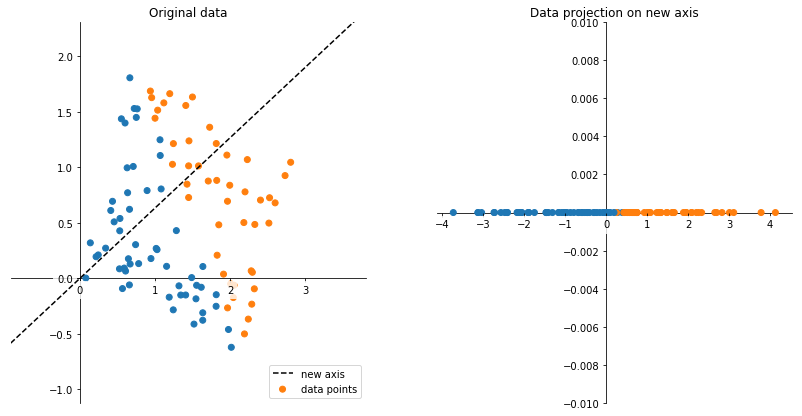

In [5]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create a toy dataset
np.random.seed(13)

n1 = np.random.random(100)           # two modes for each feature
n2 = np.random.random(100)

x1 = 2.2 * n1 + 0.7 * n2              # first feature
x2 = -0.7 * n1 + 1.9 * n2             # second feature

features = np.c_[x1, x2]              # concatenate features
labels = ((n1 + n2) > 1).astype(int)  # generate labels

# Instantiate and fit LDA
lda = LinearDiscriminantAnalysis()
new_features = lda.fit_transform(features, labels)

#                                                PLOTTING:
#                              --------------------------------------------

# Draw the data along with their new axis
plt.figure(figsize=(14, 7))

# Figure 1: data along original axes
ax = plt.subplot(121)

# Scatter the original data points
color_map = {0 : 'C0', 1 : 'C1'} 
colors = [color_map[x] for x in labels]
ax.scatter(features[:, 0], features[:, 1], c=colors, label='data points')

# Plot the new axis
new_axis = lambda x: (lda.coef_[0][1] / lda.coef_[0][0]) * x  # identify slope of new axis
ax.plot([x1.min() - 1, x1.max() + 1], [new_axis(x1.min() - 1), new_axis(x1.max() + 1)], 
        c='black', label='new axis', ls='--')

# Aesthetic parameters:
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['bottom'].set_zorder(-1)
ax.spines['left'].set_position(('data', 0))
ax.spines['left'].set_zorder(-1)
          
ax.set_xlim([x1.min() - 1, x1.max() + 1])
ax.set_ylim([x2.min() - 0.5, x2.max() + 0.5])

ax.set_title('Original data')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.8 ))
    
ax.legend(loc='lower right')

# Figure 2: data projection on new axis
ax = plt.subplot(122)

# Scatter the transformed data
ax.scatter(new_features, [0] * len(new_features), c=colors)

# Aesthetic parameters:
ax.set_title('Data projection on new axis')

yticks = ax.get_yticks()
ax.set_yticks(yticks[yticks != 0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['bottom'].set_zorder(-1)
ax.spines['left'].set_position(('data', 0))
ax.spines['left'].set_zorder(-1)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.8 ))

As mentioned, the result of LDA is a transformed feature space that maximizes class separability. The new feature space is a **linear combination** of the old one. This means that if the old features were $X = x_1, ..., x_M$, the new axis (i.e. $x_{new}$) can be written as:

$$
x_{new} = w_1 \cdot x_1 + w_2 \cdot x_2 + ... + w_M \cdot x_M = \sum_{i=1}^M{w_i \cdot x_i}  
$$

where $w_1, ..., w_M$ are a set of coefficients telling us the **impact** each of the old features have for the formulation of the new one. This new feature, as we know, maximizes class separability. As such, the coefficients can be interpreted as the impact each old feature has for separating the classes! 

In [6]:
lda.coef_

array([[6.27473314, 3.974805  ]])

In the previous example, feature $x_1$ has a larger impact because its coefficient has a larger absolute value!

Having identified which features are the most important, we can proceed to **eliminate the least important features**.  

Returning to our main example:

In [7]:
throw = 5  # how many features to throw away

_ = lda.fit_transform(X_tr, y_tr)  # we don't care about the actual transformations

weakest_features = np.argpartition(np.abs(lda.coef_[0]), throw)[:throw]  # which features to throw

print('Training set shape before feature drop:', X_tr.shape)
print('Training set shape after feature drop: ', np.delete(X_tr, weakest_features, axis=1).shape)

# If we want to actually drop the features:
# X_tr = np.delete(X_tr, weakest_features, axis=1)
# X_ts = np.delete(X_ts, weakest_features, axis=1)

Training set shape before feature drop: (750, 28)
Training set shape after feature drop:  (750, 23)


c:\users\thano\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


**Note 1**: LDA can be used on its own as a **dimensionality reduction** technique, if we simply let it transform our features to a lower-dimensional space. This however is considered a **feature extraction** technique (not a feature selection one) and will be discussed in the next session.

**Note 2**: This can also be considered and **embedded method** because we let a model select the features for us. The lines are thin...

**Note 3**: Even in the case of a discrete target variable, pearson's correlation can be relevant, if used correctly!

#### Wrapper methods

These methods create a subset of the original data and train the model on that subset. Then infer on whether or not to **add/remove features** from the subset and repeat the process. These methods usually are very **computationally expensive**.

- **Forward selection**: This methods starts out with no features and iteratively adds the feature that performed the best. It continues until a new variable doesn't improve the performance of the model anymore.
- **Backward elimination**: This method starts removing the least significant features one-by-one until this starts negatively  impacting the performance of the model.
- **Recursive Feature elimination (RFE)**: This method recursively finds the best and worst performing feature and eliminates them from the subset, until all features are exhausted. Finally, it ranks the features based on their performance.

Scikit-learn supports RFE [with](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) and [without](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) cross-validation.

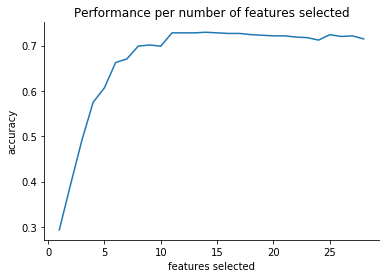

In [8]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import warnings

# Need to ignore annoying ConvergenceWarnings 
warnings.filterwarnings('ignore')

# We'll chose a simple classifier for this task
clf = LogisticRegression(solver='lbfgs', multi_class='auto')  # parameters are used to mute FutureWarnings

# Create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=clf, cv=2, scoring='accuracy')  # 2-fold CV, measure the accuracy score of each iteration
rfecv.fit(X_tr, y_tr)

#                                                PLOTTING:
#                              --------------------------------------------

# Plot scores for each feature subset
ax = plt.subplot(111)
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

ax.set_title('Performance per number of features selected')
ax.set_xlabel('features selected')
ax.set_ylabel('accuracy')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Let's analyze the figure above.

- A single feature obviously achieves the worst performance because the information it can carry is **limited**.
- As we increase the number of features the performance steadily **increases** as well. This is because we are providing the model with more information.
- After $10$ features, we reach a point where the performance **plateaus**. The features from now on provide **no new information** to the model and are useless.
- As we move forward the performance **decreases**. This is happening because the large number of irrelevant features actually **confuse** the model.

The major downside of wrapper methods is their **computation time**. They require training models on subsets multiple times for figuring which features are the most important and **don't scale well** as the data's dimensionality increases.

#### Embedded Methods

Some algorithms contain methods for estimating the importance  of each feature (e.g. L1/L2-regularized linear models, tree-based models). Why not use these models to help us determine which features are most important?

To do this with scikit-learn, the only required is a model that either has a `coef_` attribute or a `feature_importances_` one. The first are usually found in linear models ([`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge), [`SVC` with linear kernel](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), etc.), while the second are found in tree-based models ([`DecisionTree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), [`RandomForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), [`GradientBoosting`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier), etc.).

Most people prefer a high-bias model for feature selection, because they are proven to be the most robust for this use. In this spirit we'll use a simple **L1-regularized linear model**.

Values of Lasso's alpha: [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]


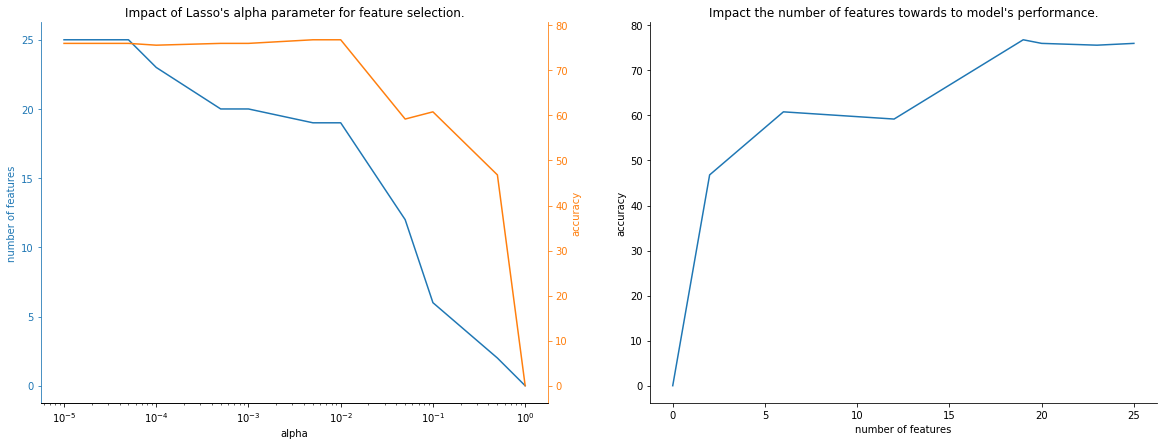

In [9]:
#                                                  CODE:
#                              --------------------------------------------

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Create values of alpha to check on a logarithmic scale
a1 = [10 ** (-i) for i in range(6)]
a2 = [5 * 10 ** (-i) for i in range(1, 6)]
alphas = [None] * (len(a1)+len(a2))
alphas[::2] = a1
alphas[1::2] = a2
print('Values of Lasso\'s alpha:', alphas)

# Loop through all values of alpha and see how many features they discard
# and what performance a model trained on those features achieves.
num_features = []
accuracies = []

for alpha in alphas:
    # Instantiate a Lasso regression model using a given alpha,
    # train it and use it for feature selection.
    selector = SelectFromModel(Lasso(alpha=alpha))
    X_subset = selector.fit_transform(X_tr, y_tr)
    # Store how many features it has kept
    num_features.append(X_subset.shape[1])
    # Evaluate the performance of a model trained on the subset.
    if X_subset.shape[1] == 0:  # Bypass the case where all features are discarded
        accuracies.append(0)
        continue
    evaluation_model = LogisticRegression()
    evaluation_model.fit(X_subset, y_tr)
    X_ts_sub = selector.transform(X_ts)
    accuracies.append(accuracy_score(y_ts, evaluation_model.predict(X_ts_sub)) * 100)

#                                                PLOTTING:
#                              --------------------------------------------

# Plot results    
plt.figure(figsize=(20,7))

# First plot: alpha - features/accuracy (dual scale plot)
# First scale: features
ax1 = plt.subplot(121)
ax1.semilogx(alphas, num_features)
ax1.set_ylabel('number of features', color='C0')
ax1.set_xlabel('alpha')
ax1.set_title('Impact of Lasso\'s alpha parameter for feature selection.')
ax1.tick_params('y', colors='C0')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color('C0')
# Second scale: accuracy
ax2 = ax1.twinx()
ax2.semilogx(alphas, accuracies, c='C1')
ax2.set_ylabel('accuracy', color='C1')
ax2.tick_params('y', colors='C1')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_visible(False)

# Second plot: features - accuracy
ax3 = plt.subplot(122)
ax3.plot(num_features, accuracies)
ax3.set_xlabel('number of features')
ax3.set_ylabel('accuracy')
ax3.set_title('Impact the number of features towards to model\'s performance.')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

The hyperparameter `alpha` we played with indicates the strength of the **regularization**. A higher value for alpha means that more features are discarded. As we said previously, the model tries to keep the **most relevant** features, i.e. the most important features for the model.

As expected, more features means a better accuracy, up to a point. Afterwards the accuracy becomes stagnant and even drops a bit.

Another thing to note is that there is no a-priori indication of how many features a certain value of alpha will discard. Thus, `alpha` becomes a very important hyperparameter to optimize during the whole ML workflow. 

To sum up, feature selection usually comes as a tradeoff:

- On one hand, throwing away features might mean **discarding (possible useful) information**, which will hurt the model's performance. 
- On the other hand, there are many benefits to feature selection: Models trained under a smaller subset usually experience **improved generalization** (they can focus on important features and not overfit on noisy ones), **reduced training times** and we can usually **interpret** the result better.

Feature selection is especially useful when performing an Exploratory Data Analysis task, where we want to see which input variables impact the target one the most, and how.

### Feature Extraction

Similar to feature selection, the goal of feature extraction is **dimensionality reduction**. However, it approaches it differently. Instead of selecting the best subset out of the existing features, feature extraction aims at **transforming** the original features into new ones, usually less in number. Thus, the new features are **different** than the old ones. The goal is that the new, smaller, feature space will not lose much of the information the original features carried.

One major negative of feature extraction is that the new features, usually, have **no real world interpretation**. This makes the solutions much less interpretable, which in some applications is unacceptable. For this reason, feature extraction techniques are primarily used when dealing with **unstructured data** (e.g. text, images), which tend to be very high-dimensional and whose features had no real-world interpretation to begin with.

Nevertheless, in some applications where either interpretation is not required or dimensionality reduction is mandatory, feature extraction techniques are quite popular. 

We've actually seen a feature extraction technique earlier: LDA. Yes, LDA does exactly that! It creates a series of new features (as linear combinations of the old ones) and transforms the data into the new feature space. After training an LDA, we get a lower-dimensional projection of our data!

Another very well known feature extraction technique is **[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA)**. PCA is much similar to LDA, in that it is a linear transformation algorithm that decomposes our features into a new set of features (this time called *principal components*).  These are orthogonal and **linearly uncorrelated**. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible). We can reconstruct the original data if we have all derived components. However, if we attempt to reconstruct the data through the first $m < n$ components we will have the **best reconstruction possible** (that accounts for most of the variability in the data).

We won't go much into how PCA works, as we're more interested in the concept of *feature extraction* than how a particular algorithm works. A nice tutorial on PCA can be found [here](https://plot.ly/ipython-notebooks/principal-component-analysis/)!

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # we want to keep the 5 first components

X_decomposed = pca.fit_transform(X_tr)
X_decomposed_ts = pca.transform(X_ts)

print('original shape:        ', X_tr.shape)
print('shape after extraction:', X_decomposed.shape)

original shape:         (750, 28)
shape after extraction: (750, 5)


As we said PCA decomposes the data into components that explain the most variability in the data. Let's see how much of the variance is preserved per number of components.

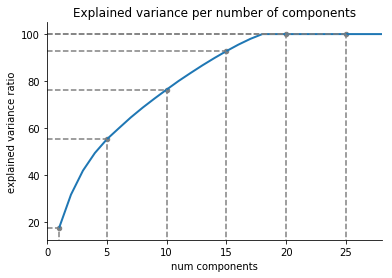

In [11]:
#                                                  CODE:
#                              --------------------------------------------

# Fit a PCA with as many components as the dataset has features.
pca = PCA(n_components=X_tr.shape[1])
pca.fit(X_tr)

# Incrimentally calculate the explained variance ratio for each number of components.
variance_ratio = [pca.explained_variance_ratio_[:i].sum() * 100 
                  for i in range(1, len(pca.explained_variance_ratio_) + 1)]
    
#                                                PLOTTING:
#                              --------------------------------------------

# Plot explained varince ratio per number of components.
ax = plt.subplot(111)
ax.plot(range(1, X_tr.shape[1] + 1), variance_ratio, lw=2)

ax.set_title('Explained variance per number of components')
ax.set_xlabel('num components')
ax.set_ylabel('explained variance ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(variance_ratio[0]-5, variance_ratio[-1]+5)
ax.set_xlim(0, X_tr.shape[1])

points = [1, 5, 10, 15, 20, 25]
for p in points:
    ax.scatter([p], [variance_ratio[p-1]], s=20, c='0.5')
    ax.plot([0, p], [variance_ratio[p-1], variance_ratio[p-1]], ls='--', c='0.5')
    ax.plot([p, p], [0, variance_ratio[p-1]], ls='--', c='0.5')

With $5$ components, we manage to explain around $55\%$ of the total variance in the training set, while if we use $10$ features that number goes up to around $75\%$. We need $18$ components to describe the total variance in the data.

Note that this is **not** a measure of how well our model is going to perform on this data. PCA, even with a large number of components, might hurt performance in several occasions. The explained ratio can be used as an **indication** of how well we described the original dataset.

Let's see PCA's actual impact to classification.

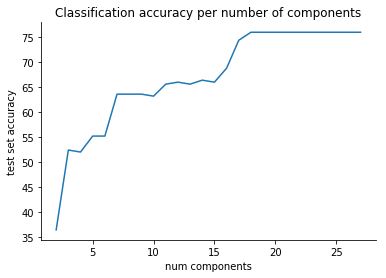

In [12]:
#                                                  CODE:
#                              --------------------------------------------

accuracies = []

for n_components in range(2, X_tr.shape[1]):
    pca = PCA(n_components=n_components)
    X_tr_reduced = pca.fit_transform(X_tr)
    X_ts_reduced = pca.transform(X_ts)
    evaluation_model.fit(X_tr_reduced, y_tr)
    accuracies.append(accuracy_score(y_ts, evaluation_model.predict(X_ts_reduced)) * 100)

#                                                PLOTTING:
#                              --------------------------------------------

ax = plt.subplot(111)
ax.plot(range(2, X_tr.shape[1]), accuracies)

ax.set_title('Classification accuracy per number of components')
ax.set_xlabel('num components')
ax.set_ylabel('test set accuracy')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Generally speaking, the more components, the better the performance of the classifier.

### Over/Under Sampling

We'll now transition to a totally different aiming at changing, not the number of features as we say previously, but the number of **samples** in a dataset. This preprocessing step is usually applied to counter **class imbalance**. 

For simplicity let's suppose we have a binary classification problem, with a $9:1$ imbalance ratio. This means that for every $1$ sample of one class we have $9$ from the other. The class with the small number of samples will be referred to as the **minority** or **underrepresented** class, while the other one will be called the **majority** or **overrepresented** class.

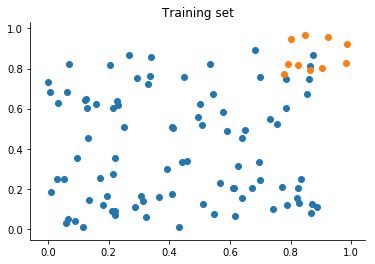

In [13]:
#                                                  CODE:
#                              --------------------------------------------

np.random.seed(13)

x1a = np.random.random(size=90) * 0.9
x1b = np.random.random(size=90) * 0.9

x2a = np.random.random(size=10) * 0.25 + 0.75
x2b = np.random.random(size=10) * 0.25 + 0.75

data = pd.DataFrame({'x1': np.r_[x1a, x2a],
                     'x2': np.r_[x1b, x2b],
                     'y': [0] * 90 + [1] * 10})

#                                                PLOTTING:
#                              --------------------------------------------

ax = plt.subplot(111)
ax.scatter(x1a, x1b)
ax.scatter(x2a, x2b)

ax.set_title('Training set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The above illustrates a binary classification dataset with $100$ samples with a $9:1$ imbalance ratio.

The goal is to resample the data in such a way that we'll get a **fairly balanced** dataset. How can this be accomplished?

- **Oversample** the minority class:  
increase its population so that it reaches the that of the majority class.
- **Undersample** the majority class:  
decrease its population so that it reaches that of the minority class.
- **Combination** of both over and undersampling techniques:  
both increase the minority class' population and decrease that of the majority class.


  class   |  0  |  1
   ---    | --- | ---
**original samples** |  90 | 10
**oversampling**  |  90  |  90
**undersampling** |  10  |  10
**combination**   |  50  |  50

#### Oversampling

The easiest way to perform oversampling is to **randomly** repeat each sample of the minority class until it reaches the population of the majority class.

In [14]:
# Slice the DataFrame for ease
minority = data[data['y'] == 1]
majority = data[data['y'] == 0]

# Calculate how many times the whole minority set needs to be repeated
full_repetitions = len(majority) // len(minority)

# Calculate how many more individual sample repetitions have to be made
remaining = len(majority) % len(minority)

# Repeat the whole minority set
rep_array = np.repeat(minority.values, full_repetitions, axis=0)

# Repeat individual samples 
rem_array = minority.iloc[np.random.randint(0, len(minority), remaining)].values

# Join the two oversampled sets
oversampled_minority = np.r_[rep_array, rem_array]

# Join the oversampled minority set with the majority one
oversampled_data = pd.DataFrame(np.r_[majority.values, oversampled_minority], columns=majority.columns)

print(' Before oversampling')
print('Majority samples:', len(majority))
print('Minority samples:', len(minority))
print('Dataset size:    ', len(data))
print('\n After oversampling')
print('Minority samples: ', len(oversampled_minority))
print('Minority samples: ', len(majority))
print('Dataset size:     ', len(oversampled_data))

 Before oversampling
Majority samples: 90
Minority samples: 10
Dataset size:     100

 After oversampling
Minority samples:  90
Minority samples:  90
Dataset size:      180


If we viewed the oversampled dataset, we wouldn't see much of a difference, because the new samples will be placed right on top of the old ones.

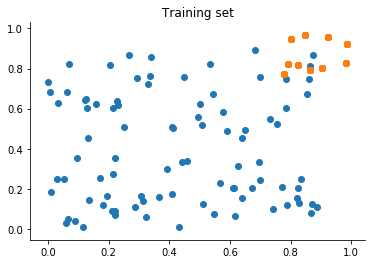

In [15]:
minority = oversampled_data[oversampled_data['y'] == 1]
majority = oversampled_data[oversampled_data['y'] == 0]

ax = plt.subplot(111)
ax.scatter(majority['x1'], majority['x2'])
ax.scatter(minority['x1'], minority['x2'])

ax.set_title('Training set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Keep in mind that we don't have to write our own oversamplers. There is a library called [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) (or simply *imblearn*) that offers a multitude of data resampling techniques. For example, let's implement a [RandomOverSampler](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler).

In [16]:
from imblearn.over_sampling import RandomOverSampler  # import sampler

X = data.drop('y', axis=1).values    # training examples (without labels)
y = data['y'].values                 # training labels

ros = RandomOverSampler()            # instantiates the sampler
X_os, y_os = ros.fit_resample(X, y)  # fits the sampler and resamples the dataset

print('Dataset size before oversampling:', len(X))
print('Dataset size after oversampling: ', len(X_os))

Dataset size before oversampling: 100
Dataset size after oversampling:  180


Randomly repeating samples isn't the smartest thing we can do... What we are essentially doing in random oversampling is creating new, synthetic samples **on top** of the original ones. What if we created synthetic samples **close** to the real ones instead?

How could this be achieved?

We'll start by taking the minority samples one-by-one and identifying their **closest minority sample**. Then we'll draw the lines that **connect** those together and repeat the process multiple times without allowing the same lines to be drawn.

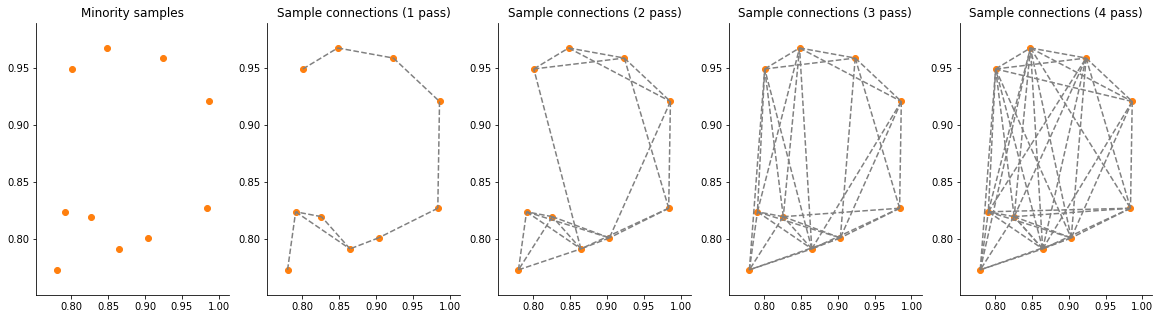

In [17]:
#                                                  CODE:
#                              --------------------------------------------

from scipy.spatial.distance import pdist, squareform

minority = data[data['y'] == 1]

# Compute sample distances and set 0 distance to max
dists = squareform(pdist(minority.drop('y', axis=1).values))
dists = np.where(dists == 0, dists.max(), dists)

pairs = []

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(20, 5))

# Figure 1: draw the samples
ax = plt.subplot(151)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Minority samples')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Figure 2: draw the samples and the 1-step closest connections 
ax = plt.subplot(152)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (1 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')

# Figure 3: draw the samples and the 2-step closest connections     
ax = plt.subplot(153)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (2 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')
    

# Figure 4: draw the samples and the 3-step closest connections     
ax = plt.subplot(154)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (3 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')

# Figure 4: draw the samples and the 4-step closest connections        
ax = plt.subplot(155)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (4 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')

Then we'll create **synthetic samples** somewhere **randomly** along these lines!

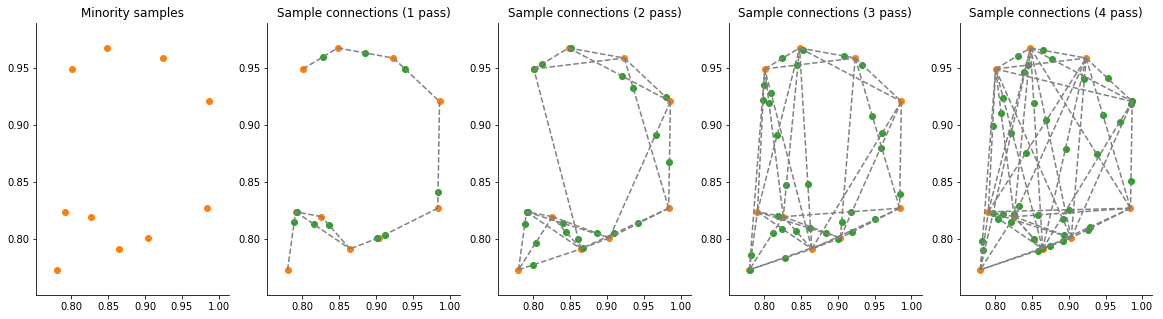

In [18]:
#                                                  CODE:
#                              --------------------------------------------

def spawn_sample(x1, x2):
    """
    spawns a synthetic sample between points x1 and x2
    """
    slope = (x1[1] - x2[1]) / (x1[0] - x2[0])           # calculate the slope of the line between x1 and x2
    line = lambda x: slope * (x - x1[0]) + x1[1]        # define the line function
    rnd = (x2[0] - x1[0]) * np.random.random() + x1[0]  # select random x-axis value between x1 and x2
    return rnd, line(rnd)                               # return the point


# Compute sample distances and set 0 distance to max
dists = squareform(pdist(minority.drop('y', axis=1).values))
dists = np.where(dists == 0, dists.max(), dists)

pairs = []

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(20, 5))

# Figure 1: draw the samples
ax = plt.subplot(151)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Minority samples')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Figure 2: draw the samples and the 1-step closest connections 
ax = plt.subplot(152)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (1 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')
    synthetic_sample = spawn_sample((minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][0]]['x2']),
                                    (minority.iloc[pairs[i][1]]['x1'], minority.iloc[pairs[i][1]]['x2']))
    plt.scatter([synthetic_sample[0]], [synthetic_sample[1]], c='C2')
# Figure 3: draw the samples and the 2-step closest connections     
ax = plt.subplot(153)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (2 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')
    synthetic_sample = spawn_sample((minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][0]]['x2']),
                                    (minority.iloc[pairs[i][1]]['x1'], minority.iloc[pairs[i][1]]['x2']))
    plt.scatter([synthetic_sample[0]], [synthetic_sample[1]], c='C2')

# Figure 4: draw the samples and the 3-step closest connections     
ax = plt.subplot(154)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (3 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')
    synthetic_sample = spawn_sample((minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][0]]['x2']),
                                    (minority.iloc[pairs[i][1]]['x1'], minority.iloc[pairs[i][1]]['x2']))
    plt.scatter([synthetic_sample[0]], [synthetic_sample[1]], c='C2')

# Figure 4: draw the samples and the 4-step closest connections        
ax = plt.subplot(155)
ax.scatter(minority['x1'], minority['x2'], c='C1')

ax.set_title('Sample connections (4 pass)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(len(dists)):
    closest = np.argmin(dists[i])
    pairs.append((i, closest))
    dists[i, closest] = dists[closest, i] = dists.max()

for i in range(len(pairs)):
    ax.plot([minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][1]]['x1']],
            [minority.iloc[pairs[i][0]]['x2'], minority.iloc[pairs[i][1]]['x2']],
            c='0.5', ls='--')
    synthetic_sample = spawn_sample((minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][0]]['x2']),
                                    (minority.iloc[pairs[i][1]]['x1'], minority.iloc[pairs[i][1]]['x2']))
    plt.scatter([synthetic_sample[0]], [synthetic_sample[1]], c='C2')

Even better, at each step we could even **incorporate the synthesized samples** into the distance calculation. This way we can create **as many synthetic samples as we want**!

Let's see how it looks now.

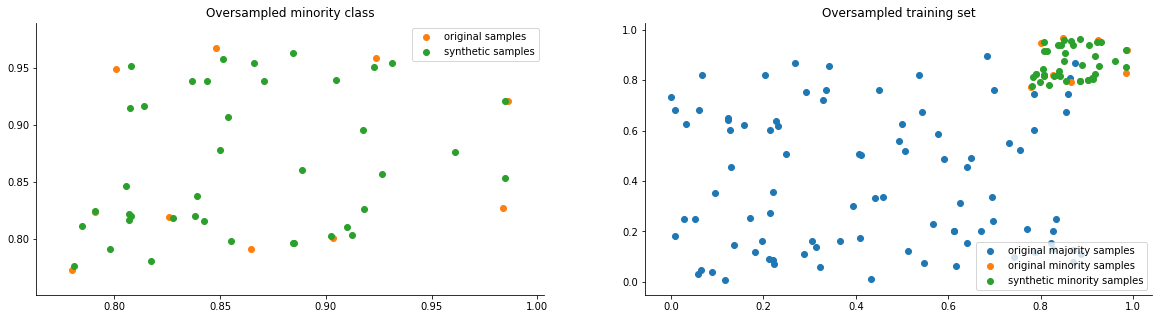

In [19]:
#                                                  CODE:
#                              --------------------------------------------

# Spawn a few synthetic samples
synthetic_samples = [spawn_sample((minority.iloc[pairs[i][0]]['x1'], minority.iloc[pairs[i][0]]['x2']),
                                  (minority.iloc[pairs[i][1]]['x1'], minority.iloc[pairs[i][1]]['x2']))
                     for i in range(len(pairs))]

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(20, 5))

# Figure 1: minority class
ax = plt.subplot(121)
ax.scatter(minority['x1'], minority['x2'], c='C1', label='original samples')
ax.scatter([x[0] for x in synthetic_samples], [x[1] for x in synthetic_samples],
           c='C2', label='synthetic samples')

ax.set_title('Oversampled minority class')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend()

# Figure 2: minority + majority classes
ax = plt.subplot(122)
ax.scatter(majority['x1'], majority['x2'], c='C0', label='original majority samples')
ax.scatter(minority['x1'], minority['x2'], c='C1', label='original minority samples')
ax.scatter([x[0] for x in synthetic_samples], [x[1] for x in synthetic_samples],
           c='C2', label='synthetic minority samples')

ax.set_title('Oversampled training set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='lower right')

This is the main idea behind the [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) algorithm, one of the best known oversampling techniques. Luckily for us, it is already implemented in *imblearn*.

Dataset size before oversampling: 100
Dataset size after oversampling:  180


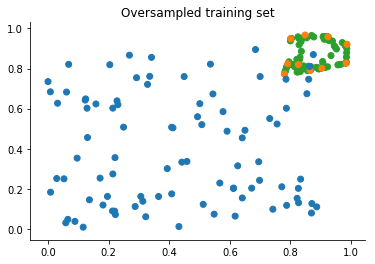

In [20]:
#                                                  CODE:
#                              --------------------------------------------

from imblearn.over_sampling import SMOTE

X = data.drop('y', axis=1).values
y = data['y'].values

smote = SMOTE()
X_os, y_os = smote.fit_resample(X, y)

print('Dataset size before oversampling:', len(X))
print('Dataset size after oversampling: ', len(X_os))

#                                                PLOTTING:
#                              --------------------------------------------

ax = plt.subplot(111)

colors = ['C0'] * len(majority) + ['C1'] * len(minority) + ['C2'] * (len(X_os) - len(X))
plt.scatter(X_os[::-1, 0], X_os[::-1, 1], c=colors[::-1])  # reverse so that real samples would be put on top of synthetic

ax.set_title('Oversampled training set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

But what effect does oversampling have to a classifier's performance?

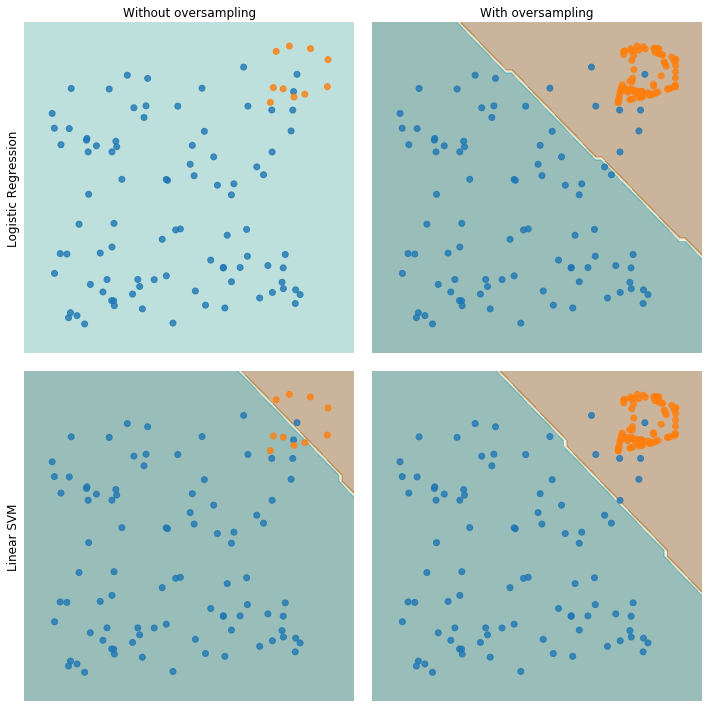

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

def plot_decision_function(X, y, clf, ax):
    """
    Function that plots the decision boundary of a classifier
    """
    # Create a meshgrid (every single point) in the same space as X 
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    # Generate a prediction for each point in the meshgrid
    # and draw contours based on the predictions
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='BrBG_r')
    
    # Scatter samples
    _, num = np.unique(y, return_counts=True)
    colors = ['C0'] * num[0] + ['C1'] * num[1]
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=colors)
    
    # Remove spines and ticks:
    for loc in ('top', 'bottom', 'left', 'right'):
        ax.spines[loc].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(10, 10))

# Logistic Regression without oversampling
ax = plt.subplot(221)
clf = LogisticRegression().fit(X, y)
plot_decision_function(X, y, clf, ax)
ax.set_ylabel('Logistic Regression', fontsize=12)
ax.set_title('Without oversampling')

# Logistic Regression with oversampling
ax = plt.subplot(222)
clf = LogisticRegression().fit(X_os, y_os)
plot_decision_function(X_os, y_os, clf, ax)
ax.set_title('With oversampling')

# Linear SVM without oversampling
ax = plt.subplot(223)
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax)
ax.set_ylabel('Linear SVM', fontsize=12)

# Linear SVM with oversampling
ax = plt.subplot(224)
clf = LinearSVC().fit(X_os, y_os)
plot_decision_function(X_os, y_os, clf, ax)

plt.tight_layout()

For both classifiers the effect of oversampling is large. Due to some of the blue samples (class $0$) "invading" the territory of the orange ones (class $1$), it is difficult for a classifier to set up a *fair* decision boundary. Oversampling forces classifiers to pay more attention to minority samples.

SMOTE is just one of the [many oversamplers](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html) offered by *imblearn*.

#### Undersampling

Undersampling aims at reducing the number of samples of the majority class, so that it reaches the population of the minority class.

Like before, the easiest thing we can do is to remove samples from the majority class **at random**. 

 Before oversampling
Majority samples: 90
Minority samples: 10
Dataset size:     100

 After oversampling
Minority samples:  10
Minority samples:  10
Dataset size:      20


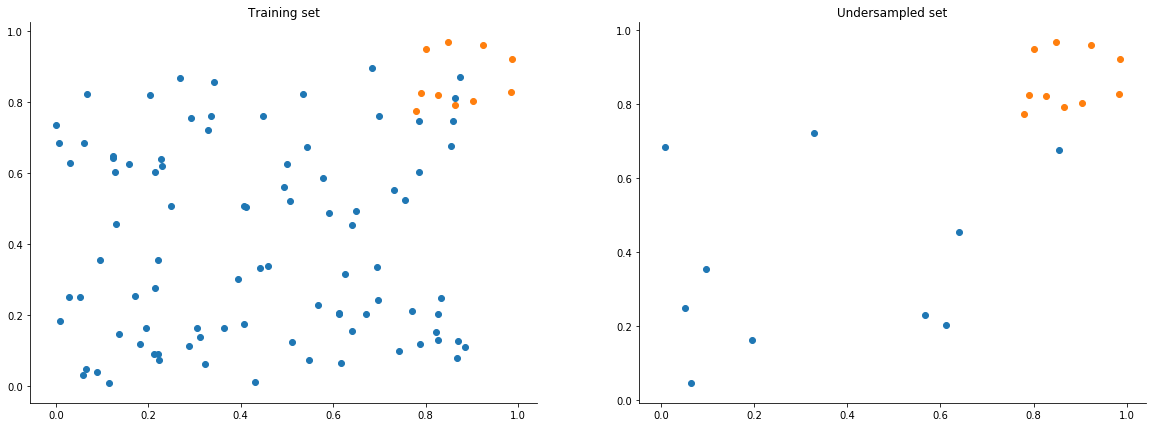

In [22]:
#                                                  CODE:
#                              --------------------------------------------

indices = np.random.choice(majority.index, size=len(minority), replace=False)
undersampled_majority = majority.iloc[indices]

undersampled_data = pd.DataFrame(np.r_[undersampled_majority, minority.values], columns=majority.columns)

print(' Before oversampling')
print('Majority samples:', len(majority))
print('Minority samples:', len(minority))
print('Dataset size:    ', len(data))
print('\n After oversampling')
print('Minority samples: ', len(minority))
print('Minority samples: ', len(undersampled_majority))
print('Dataset size:     ', len(undersampled_data))

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(20, 7))

ax = plt.subplot(121)
ax.scatter(majority['x1'], majority['x2'])
ax.scatter(minority['x1'], minority['x2'])

ax.set_title('Training set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(122)
ax.scatter(undersampled_majority['x1'], undersampled_majority['x2'])
ax.scatter(minority['x1'], minority['x2'])

ax.set_title('Undersampled set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Removing samples at random isn't the best we can do...

Why not identify which majority samples are the most **representative** and keep those?

We could run a KMeans clustering algorithm (we'll go into more details for this in a future tutorial), select as many centroids as the number of minority samples (`k = len(minority)`) and keep its centroids as the undersampled majority samples. This is implemented in *imblearn*: [`ClusteringCentroids`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.ClusterCentroids.html#imblearn.under_sampling.ClusterCentroids)

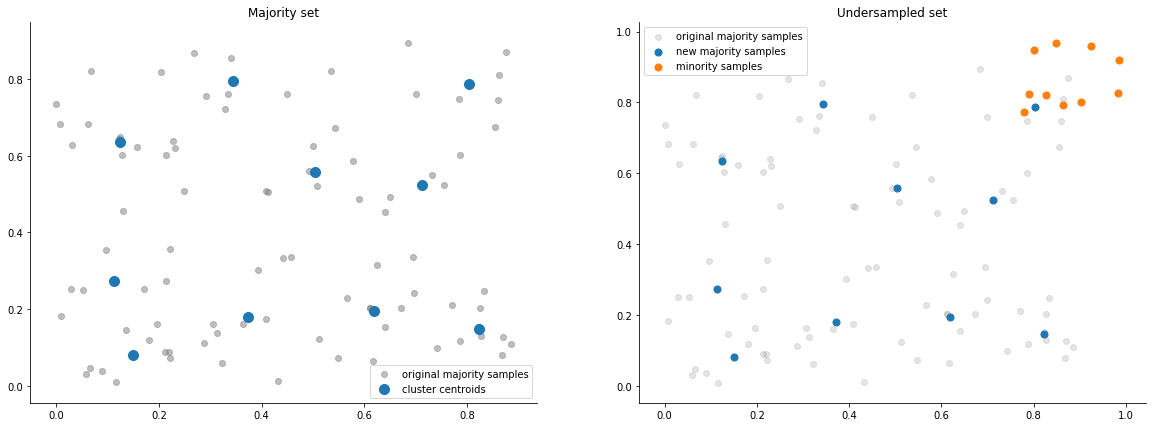

In [23]:
#                                                  CODE:
#                              --------------------------------------------

from imblearn.under_sampling import ClusterCentroids

# Undersample the majority class
cc = ClusterCentroids()
X_us, y_us = cc.fit_resample(X, y)

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(20, 7))

# Figure 1: Majority set
ax = plt.subplot(121)
ax.scatter(X[:-10, 0], X[:-10, 1], c='0.5', alpha=0.5, label='original majority samples')
ax.scatter(X_us[:10, 0], X_us[:10, 1], c='C0', s=100, label='cluster centroids')
ax.set_title('Majority set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

# Figure 2: Whole undersampled training set
ax = plt.subplot(122)
colors = ['C0'] * 10 + ['C1'] * 10
ax.scatter(X[:, 0], X[:, 1], c='0.5', alpha=0.2, label='original majority samples')
ax.scatter(X_us[:10, 0], X_us[:10, 1], c='C0', s=50, label='new majority samples')
ax.scatter(X_us[10:, 0], X_us[10:, 1], c='C1', s=50, label='minority samples')

ax.set_title('Undersampled set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

Note that this technique actually **creates new samples** for the majority set and **disregards the original samples completely**!

Another technique would be to keep some of the original majority samples and throw away the rest. But which ones would we keep? One idea would be to remove the majority samples **closest** to the minority ones. This will make our classes more **separable**. This idea used by [`EditedNearestNeighbours`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.EditedNearestNeighbours.html#imblearn.under_sampling.EditedNearestNeighbours), [`RepeatedEditedNearestNeighbours`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RepeatedEditedNearestNeighbours.html#imblearn.under_sampling.RepeatedEditedNearestNeighbours) and [`AllKNN`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.AllKNN.html#imblearn.under_sampling.AllKNN). 

All these techniques work by removing samples that have as least 1 nearest neighbour belonging to the minority class. Due to this we can't control the number of samples that we'll have in the undersampled dataset (if a sample has all of its neighbors in the majority it can't be removed). 

 Before oversampling
Majority samples: 90
Minority samples: 10
Dataset size:     100

 After oversampling
Minority samples:  10
Minority samples:  83
Dataset size:      93


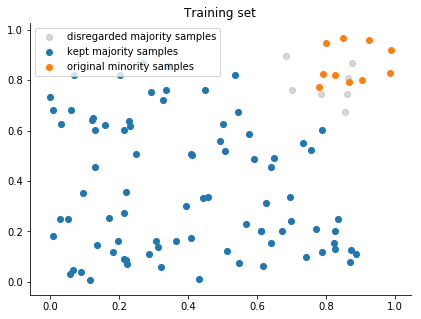

In [24]:
#                                                  CODE:
#                              --------------------------------------------

from imblearn.under_sampling import EditedNearestNeighbours

# Undersample the data
enn = EditedNearestNeighbours(n_neighbors=5)
X_us, y_us = enn.fit_resample(X, y)

# Count how many samples were removed
_, c = np.unique(y_us, return_counts=True)
print(' Before oversampling')
print('Majority samples:', len(majority))
print('Minority samples:', len(minority))
print('Dataset size:    ', len(data))
print('\n After oversampling')
print('Minority samples: ', c[1])
print('Minority samples: ', c[0])
print('Dataset size:     ', len(X_us))

#                                                PLOTTING:
#                              --------------------------------------------

# Draw figure
plt.figure(figsize=(15, 5))

ax = plt.subplot(121)
ax.scatter(X[:-10, 0], X[:-10, 1], c='0.5', alpha=0.3, label='disregarded majority samples')
ax.scatter(X_us[:c[0], 0], X_us[:c[0], 1], c='C0', label='kept majority samples')
ax.scatter(X[-10:, 0], X[-10:, 1], c='C1', label='original minority samples')
ax.set_title('Training set')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper left')

Let's see the effect undersampling has to classification.

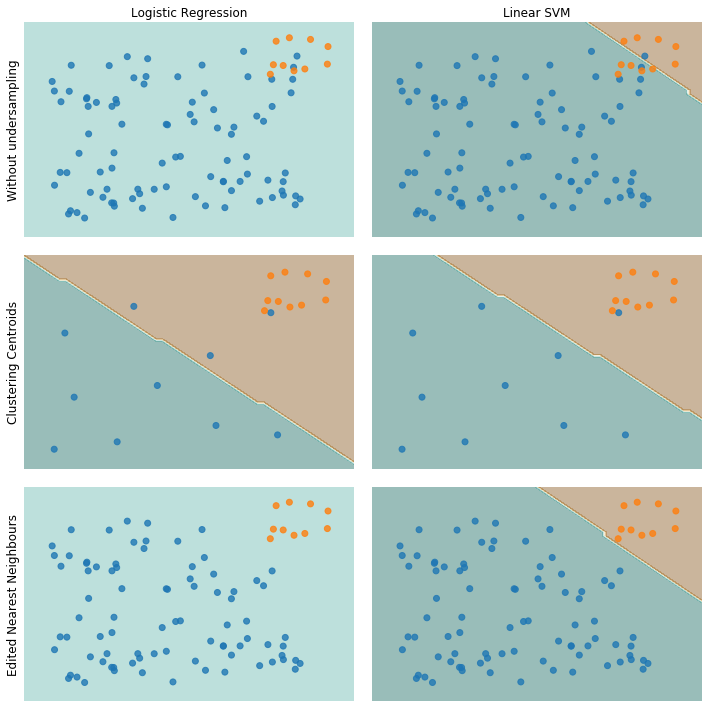

In [25]:
#                                                  CODE:
#                              --------------------------------------------

X_us_cc, y_us_cc = cc.fit_resample(X, y)
X_us_nn, y_us_nn = enn.fit_resample(X, y)

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(10, 10))

# Logistic Regression without undersampling
ax = plt.subplot(321)
clf = LogisticRegression().fit(X, y)
plot_decision_function(X, y, clf, ax)
ax.set_ylabel('Without undersampling', fontsize=12)
ax.set_title('Logistic Regression')

# Linear SVM without undersampling
ax = plt.subplot(322)
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax)
ax.set_title('Linear SVM')

# Logistic Regression with CC undersampling
ax = plt.subplot(323)
clf = LogisticRegression().fit(X_us_cc, y_us_cc)
plot_decision_function(X_us_cc, y_us_cc, clf, ax)
ax.set_ylabel('Clustering Centroids', fontsize=12)

# Linear SVM with CC undersampling
ax = plt.subplot(324)
clf = LinearSVC().fit(X_us_cc, y_us_cc)
plot_decision_function(X_us_cc, y_us_cc, clf, ax)

# Logistic Regression with ENN undersampling
ax = plt.subplot(325)
clf = LogisticRegression().fit(X_us_nn, y_us_nn)
plot_decision_function(X_us_nn, y_us_nn, clf, ax)
ax.set_ylabel('Edited Nearest Neighbours', fontsize=12)

# Linear SVM with ENN undersampling
ax = plt.subplot(326)
clf = LinearSVC().fit(X_us_nn, y_us_nn)
plot_decision_function(X_us_nn, y_us_nn, clf, ax)

plt.tight_layout()

While *Clustering Centroids* had the results we could expected from an undersampling technique, *Edited Nearest Neighbours* didn't manage to help the *Logistic Regression* very much. This happened because, even though it made the classes more separable, it **didn't remove** enough samples from the majority class, which preserved a high class imbalance. The SVM, though, showed an improved performance.

#### Over vs Under-sampling

Generally speaking, oversampling techniques tend to **outperform** undersampling. Due to the nature of most Machine Learning algorithms, they tend to get better with **more data**. Undersampling, on the other hand, carries the danger of **possibly disregarding useful majority samples**, which might **impair** a model's performance.

However, oversampling comes with an **added computation cost**, as the model now needs to be trained in a **larger** dataset. In contrast, undersampling reduces the size of the dataset, allowing for **faster training** of ML models.

Whenever possible, it is **recommended to use oversampling** for dealing with class imbalance! 

#### Combining both over and under-sampling techniques

When applying SMOTE, we might encounter some issues with synthetic samples generated from **minority outliers**. This leads to  can lead to a more *noisy* dataset. There are a few techniques that combine an undersampling technique (e.g. ENN) with SMOTE to further improve performance. The idea is to first apply ENN, which separates the classes and then apply SMOTE on the *cleaned* dataset. This algorithm is called [`SMOTEENN`](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN).

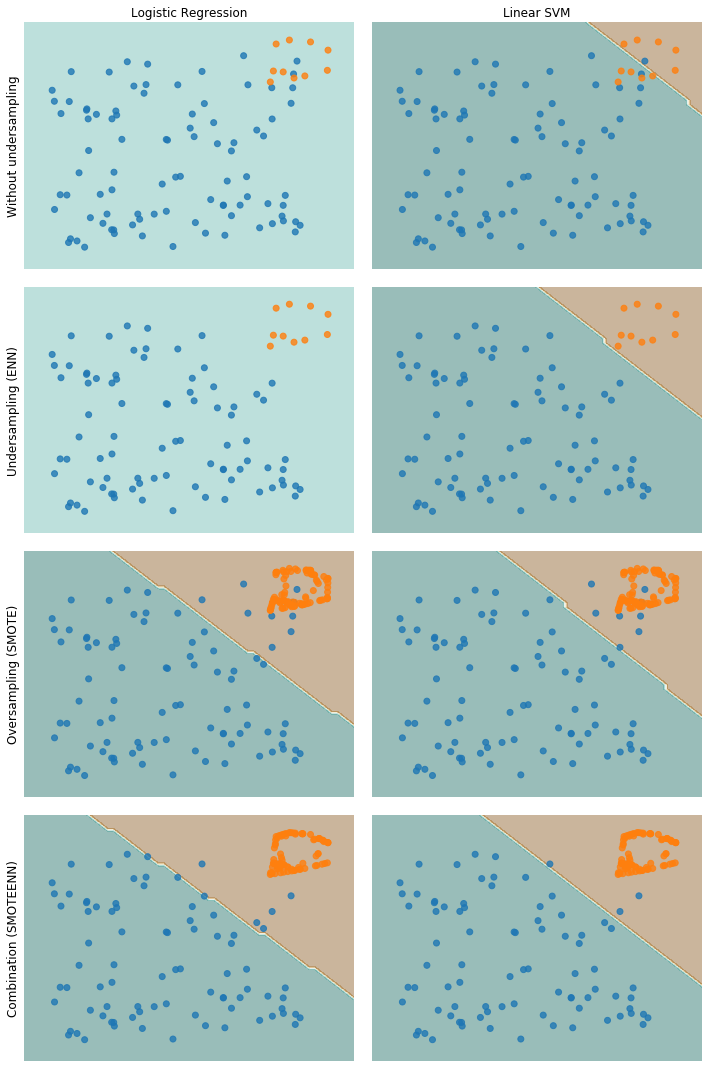

In [26]:
#                                                  CODE:
#                              --------------------------------------------

from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN()

X_us_nn, y_us_nn = enn.fit_resample(X, y)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X, y)

#                                                PLOTTING:
#                              --------------------------------------------

plt.figure(figsize=(10, 15))

# Logistic Regression without undersampling
ax = plt.subplot(421)
clf = LogisticRegression().fit(X, y)
plot_decision_function(X, y, clf, ax)
ax.set_ylabel('Without undersampling', fontsize=12)
ax.set_title('Logistic Regression')

# Linear SVM without undersampling
ax = plt.subplot(422)
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax)
ax.set_title('Linear SVM')

# Logistic Regression with ENN undersampling
ax = plt.subplot(423)
clf = LogisticRegression().fit(X_us_nn, y_us_nn)
plot_decision_function(X_us_nn, y_us_nn, clf, ax)
ax.set_ylabel('Undersampling (ENN)', fontsize=12)

# Linear SVM with ENN undersampling
ax = plt.subplot(424)
clf = LinearSVC().fit(X_us_nn, y_us_nn)
plot_decision_function(X_us_nn, y_us_nn, clf, ax)

# Logistic Regression with SMOTE oversampling
ax = plt.subplot(425)
clf = LogisticRegression().fit(X_os, y_os)
plot_decision_function(X_os, y_os, clf, ax)
ax.set_ylabel('Oversampling (SMOTE)', fontsize=12)

# Linear SVM with SMOTE oversampling
ax = plt.subplot(426)
clf = LinearSVC().fit(X_os, y_os)
plot_decision_function(X_os, y_os, clf, ax)

# Logistic Regression with SMOTEENN
ax = plt.subplot(427)
clf = LogisticRegression().fit(X_smoteenn, y_smoteenn)
plot_decision_function(X_smoteenn, y_smoteenn, clf, ax)
ax.set_ylabel('Combination (SMOTEENN)', fontsize=12)

# Linear SVM with SMOTEENN
ax = plt.subplot(428)
clf = LinearSVC().fit(X_smoteenn, y_smoteenn)
plot_decision_function(X_smoteenn, y_smoteenn, clf, ax)

plt.tight_layout()